In [1]:
import seaborn as sns
sns.set()

In [2]:
#This silences some distracting warnings that we expect to get
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# Regression
<!-- requirement: images/PML_linreg_error.svg -->
<!-- requirement: images/PML_linreg.svg -->
<!-- requirement: images/PML_linreg_matrix.svg -->
<!-- requirement: images/PML_sgd_animation.gif -->
<!-- requirement: small_data/Housing_Train_dict.pkl -->
<!-- requirement: small_data/Housing_Train.csv -->

In this notebook, I will use a housing data set and build a machine learning model that will **predict the price of a house** based on information about the house such as overall property quality, area of living space, garage area, size of the basement, and lot size.

This problem falls under the topic of **regression** which is a general term for supervised learning problems where I try to predict the value of a continuous variable.  

In [3]:
import pandas as pd
import pickle
from ipywidgets import widgets
import matplotlib.pyplot as plt


df_housing = pd.read_csv('small_data/Housing_Train.csv')
with open('small_data/Housing_Train_dict.pkl', "rb") as f:
    features_dict = pickle.load(f)

X = df_housing.drop('SalePrice', axis=1)
y = df_housing['SalePrice']

def housing_plot(X, y):
    def plotter(column):
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        plt.xlabel(features_dict[column])
        plt.ylabel('Home price ($)')
    
    return plotter

dropdown_values = {"{0}: {1}".format(k, features_dict[k]):k for k in X.columns}
widgets.interact(housing_plot(X, y), column=dropdown_values);

interactive(children=(Dropdown(description='column', options={'Id: sale id': 'Id', 'MSSubClass: The building c…

## Linear regression with a single feature

First I'll use a single feature from our data set and build a linear regression model to predict house price. I will use the total square feet of above ground living area (column `'GrLivArea'`)

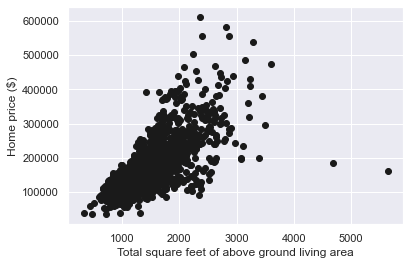

In [4]:
X = df_housing[['GrLivArea']]
y = df_housing['SalePrice']

plt.plot(X, y, 'o', color='k');
plt.xlabel(features_dict['GrLivArea'])
plt.ylabel('Home price ($)');

Training a linear model on this data means finding the coefficient $\beta$ and intercept $\beta_0$ so that $f(X) = X\cdot\beta+\beta_0$ best approximates our label variable $y$, thus best fits the points we plotted above.

I will import `LinearRegression` from scikit-learn, make an instance of the model and train it by using the `fit` method.

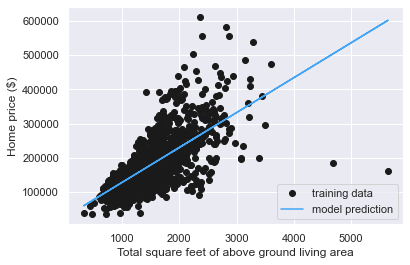

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()  # make an instance of the model 
lr.fit(X, y)             # fit the model

y_pred = lr.predict(X)

plt.plot(X, y, 'o', color = 'k', label='training data')
plt.plot(X, y_pred, color='#42a5f5ff', label='model prediction')
plt.xlabel('Total square feet of above ground living area')
plt.ylabel('Home price ($)')
plt.legend();

In [ ]:
print('One feature linear model R^2 on training data set: {}'.format(lr.score(X, y)))

## Linear regression with multiple features

Then I will build a linear model by using more than a single feature. I will predict home price by using total square feet of above ground living area, overall property quality, year the house was built, lot area, and total basement area as features.

In [8]:
features = ['GrLivArea', 'OverallQual', 'YearBuilt', 'LotArea', 'TotalBsmtSF']
X = df_housing[features]
y = df_housing['SalePrice']

lr_many_features = LinearRegression()
lr_many_features.fit(X, y);

This model learns a coefficient for each feature as well as an intercept term, and then makes predictions by returning the corresponding linear combination.  

In [9]:
print(('prediction = ' +
       '{} +\n'.format(lr_many_features.intercept_) +
       ' +\n'.join(['{} * {}'.format(n, f) for f, n in zip(features, lr_many_features.coef_)])))

prediction = -926018.390867547 +
46.97643750972096 * GrLivArea +
23205.832760644684 * OverallQual +
435.1870549158546 * YearBuilt +
0.7159409311875938 * LotArea +
26.735607541976787 * TotalBsmtSF


In [10]:
print('Multiple features linear model R^2 on training data set: {}'.format(lr_many_features.score(X, y)))

Multiple features linear model R^2 on training data set: 0.7647485465855067


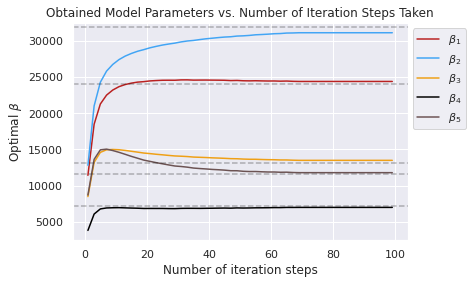

In [11]:
from sklearn.linear_model import SGDRegressor
import numpy as np

from sklearn.preprocessing import StandardScaler

colors = ['#ba2121ff', '#42a5f5ff', '#efa016ff', '#000000ff', '#6c5353ff']

def fit_SGD(X, y, random_state, eta0, max_iter):
    # SGD will perform much better if we scale the data!
    X_scaled = StandardScaler().fit_transform(X)
    return SGDRegressor(random_state=random_state, eta0=eta0, max_iter=max_iter).fit(X_scaled, y)

coefs = []
iterations = range(1, 100, 2)
for n_iter in iterations:
    sgd_regressor = fit_SGD(X, y, random_state=42, eta0=0.001, max_iter=n_iter)
    coefs.append(sgd_regressor.coef_)

for idx, c in enumerate(np.array(coefs).T):
    plt.plot(iterations, c, label=r'$\beta_{}$'.format(idx+1),
            color=colors[idx])

# Obtain same coefficients with LinearRegression:
X_scaled = StandardScaler().fit_transform(X)
lr = LinearRegression().fit(X_scaled, y);
for coeff in lr.coef_:
    plt.axhline(y=coeff, color='k', linestyle='--', alpha=0.3)
    
plt.ylabel(r'Optimal $\beta$')
plt.xlabel('Number of iteration steps')
plt.title('Obtained Model Parameters vs. Number of Iteration Steps Taken')
plt.legend(bbox_to_anchor=(1, 1));

## Adding features

Training R^2: 0.28922875346789956


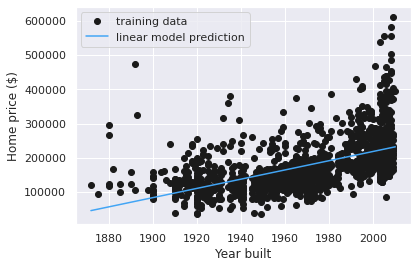

In [12]:
X = df_housing[['YearBuilt']].copy()
y = df_housing['SalePrice']

lr_year_built = LinearRegression()
lr_year_built.fit(X, y) 

y_pred = lr_year_built.predict(X)

plt.plot(X, y, 'o', color = 'k', label='training data')
plt.plot(X, y_pred, color='#42a5f5ff', label='linear model prediction')
plt.xlabel('Year built')
plt.ylabel('Home price ($)')
plt.legend()

print("Training R^2:", metrics.r2_score(y, y_pred))

In [13]:
X['QuadYear'] = X['YearBuilt']*X['YearBuilt'] # augmented feature matrix with columns YearBuilt and YearBuilt**2
X.head()

,YearBuilt,QuadYear
0,1872,3504384
1,1875,3515625
2,1880,3534400
3,1880,3534400
4,1880,3534400


Training R^2: 0.3711179443417415


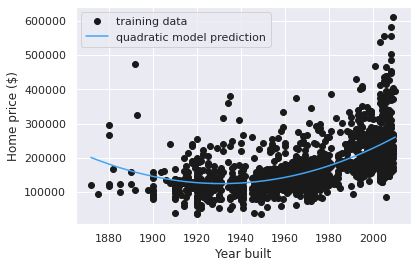

In [14]:
lr_year_built.fit(X, y)   # fit the model on the enhanced data matrix

y_pred = lr_year_built.predict(X)

print('Training R^2:', metrics.r2_score(y, y_pred))

plt.plot(X['YearBuilt'], y, 'o', color='k', label='training data')
plt.plot(X['YearBuilt'], y_pred, color='#42a5f5ff', label='quadratic model prediction')
plt.xlabel('Year built')
plt.ylabel('Home price ($)')
plt.legend();

## Regularization

One thing to do in hopes of obtaining a better fit is to add even more complexity to a linear model by further increasing the number of features I create. I added a quadratic column, add more polynomial features to the data matrix. That is exactly what scikit-learn's [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer does. It generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. I'll scale our data using the `MinMaxScaler` first to get it into the range `(-1,1)`, which will be maintained after the polynomial transformation.

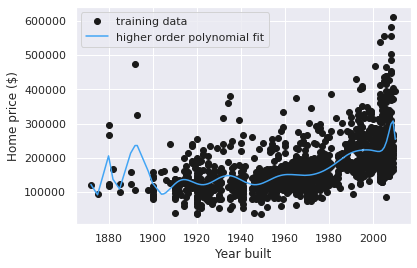

In [15]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline

X = df_housing[['YearBuilt']].copy()
y = df_housing['SalePrice']

lr_poly = Pipeline([('standard_scaler', MinMaxScaler((-1,1))),
                    ('polynomial_trans', PolynomialFeatures(20)),
                    ('lr', LinearRegression())])

lr_poly.fit(X, y)
y_pred = lr_poly.predict(X)

plt.plot(X['YearBuilt'], y, 'o', color='k', label='training data')
plt.plot(X['YearBuilt'], y_pred, color='#42a5f5ff', label='higher order polynomial fit')
plt.xlabel('Year built')
plt.ylabel('Home price ($)')
plt.legend();

In [16]:
print('Training R^2:', lr_poly.score(X, y))

Training R^2: 0.4078040388780758


I'll address overfitting of our model by using [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regression in scikit-learn. I will make a pipeline with `MinMaxScaler`, `PolynomialFeatures`, then `Ridge`, Note that `PolynomialFeatures` usually performs better after scaling (so by first scaling the data and then passing it through `PolynomialFeatures`).

In [ ]:
from sklearn.linear_model import Ridge

ridge_est = Pipeline([('standard_scaler', MinMaxScaler((-1,1))),
                      ('polynomial_trans', PolynomialFeatures(20)),
                      ('ridge', Ridge(alpha=10))])


ridge_est.fit(X, y)
y_pred = ridge_est.predict(X)

plt.plot(X['YearBuilt'], y, 'o', color='k', label='training data')
plt.plot(X['YearBuilt'], y_pred, color='#42a5f5ff', label='ridge model')
plt.xlabel('Year built')
plt.ylabel('Home price ($)')
plt.legend();

Notice that the model appears to overfit less, but the hyperparameter $\alpha$ that I chose might not be optimal. In order to obtain the best model, I would need to find the best value of $\alpha$. 